## Exploratory Data Analysis and Feature Engineering
Here we work with adjusted options data from the `data/adjusted_options` directory. We aim to produce
a novel technical indicator to be used for training of model

**Importing required packages & changing working directory**

In [91]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import os

if os.getcwd()[-3:] == "src":
    os.chdir(os.path.dirname(os.getcwd()))
else:
    pass

**User defined parameters**

In [92]:
stock_of_interest = "CVX"
option_data_path = "data/adjusted_options/"
stock_data_path = "data/adjusted_daily_closing/"
num_bars = 100


**Load adjusted options data**


In [93]:
try:
    options_df = pd.read_csv(os.path.abspath(os.path.join(option_data_path, stock_of_interest)) + ".csv")
    options_df["date"] = pd.to_datetime(options_df["date"]).dt.date
    options_df["expiration date"] = pd.to_datetime(options_df["expiration date"]).dt.date
except FileNotFoundError:
    raise SystemExit("Option data for " + stock_of_interest + " not found in path: " +
                     os.path.abspath(os.path.join(option_data_path, stock_of_interest)) + ".csv")


First off, it is important to point out that we are only using `bid price` or `last price` as a measure of an option's value.
This is because, we are focused on the selling of options, and `ask price` is an exaggerated representation of demand.

Thus, we first remove options that neither have bid or last price, as we cannot determine demand. In addition, we will
also remove options that have neither volume nor open interest. I made this decision because I believe that options
that have no holders and liquidity is not representative of the market, as the `last price` may be outdated and
`bid price` undervalued.

In [94]:
options_df = options_df[(options_df[["bid price", "last price"]].max(axis=1) > 0) &
                        (options_df[["volume", "open interest"]].max(axis=1) > 0)]
options_df.head()

,date,expiration date,type,strike price,ask price,ask size,bid price,bid size,last price,volume,open interest,closing price,exp date closing price,date div,exp date div
9,2016-01-04,2016-01-08,put,65.0,0.25,173.0,0.00,0.0,0.01,0.0,13.0,88.85,82.13,0.578852,0.649016
10,2016-01-04,2016-01-08,call,70.0,19.15,27.0,17.45,344.0,10.83,0.0,1.0,88.85,82.13,0.578852,0.649016
11,2016-01-04,2016-01-08,put,70.0,0.03,28.0,0.00,0.0,0.04,0.0,173.0,88.85,82.13,0.578852,0.649016
13,2016-01-04,2016-01-08,put,75.0,0.05,418.0,0.01,36.0,0.02,162.0,1506.0,88.85,82.13,0.578852,0.649016
15,2016-01-04,2016-01-08,put,76.5,0.04,117.0,0.02,25.0,0.02,291.0,11.0,88.85,82.13,0.578852,0.649016


Since the option strike price, closing price on current and expiration dates all contain priced in dividends,
we will remove these with the pre-calculated dividend contributions. This is done in script `scrape_and_preprocess.py`.

In [95]:
options_df["adj closing"] = options_df["closing price"] - options_df["date div"]
options_df["adj strike"] = options_df["strike price"] - options_df["exp date div"]
options_df["adj exp closing"] = options_df["exp date closing price"] - options_df["exp date div"]
options_df["days till exp"] = np.busday_count(begindates=options_df["date"],
                                              enddates=options_df["expiration date"])
options_df = options_df.drop(columns=["date div", "exp date div"])

options_df.head()

,date,expiration date,type,strike price,ask price,ask size,bid price,bid size,last price,volume,open interest,closing price,exp date closing price,adj closing,adj strike,adj exp closing,days till exp
9,2016-01-04,2016-01-08,put,65.0,0.25,173.0,0.00,0.0,0.01,0.0,13.0,88.85,82.13,88.271148,64.350984,81.480984,4
10,2016-01-04,2016-01-08,call,70.0,19.15,27.0,17.45,344.0,10.83,0.0,1.0,88.85,82.13,88.271148,69.350984,81.480984,4
11,2016-01-04,2016-01-08,put,70.0,0.03,28.0,0.00,0.0,0.04,0.0,173.0,88.85,82.13,88.271148,69.350984,81.480984,4
13,2016-01-04,2016-01-08,put,75.0,0.05,418.0,0.01,36.0,0.02,162.0,1506.0,88.85,82.13,88.271148,74.350984,81.480984,4
15,2016-01-04,2016-01-08,put,76.5,0.04,117.0,0.02,25.0,0.02,291.0,11.0,88.85,82.13,88.271148,75.850984,81.480984,4


*Definition:* Breakeven price - the price of a stock at expiry such that selling an option at the current bid/last price
causes no gain or loss.
    - Example: Say the current price of TSLA is $100. We sell a $90 call option for $15 expiring in one month. Therefore, the "breakeven" expiration price will be $105. If the price is higher, we lose, and vice versa.

Since breakeven price for calls and puts are calculated differently, we first split into respective categories.

In [96]:
calls_df = options_df[options_df["type"] == "call"]
puts_df = options_df[options_df["type"] == "put"]

Now comes the question of whether we should use the "bid" or "last" price for these options. Although not necessarily
true, the following assumptions are made:
    - If the volume of an option is not 0, then the "last" price is used, as it is often in between the bid and ask prices.
    - If the volume is 0, then the "bid" price is used, as we are uncertain when the "last" price was most recently updated.
    - In the case that "bid" is 0 (most likely due to inactivity of that option for that specific day), "last" price is used regardless of volume.

Each of the call and put DataFrames are further split into ones where "last price"(lp) is used vs. "bid price"(bp).

In [97]:
calls_df_lp = calls_df[(calls_df["volume"] > 0) | (calls_df["bid price"] == 0)].copy()
puts_df_lp = puts_df[(puts_df["volume"] > 0) | (puts_df["bid price"] == 0)].copy()

calls_df_bp = calls_df[(calls_df["volume"] == 0) & (calls_df["bid price"] != 0)].copy()
puts_df_bp = puts_df[(puts_df["volume"] == 0) & (puts_df["bid price"] != 0)].copy()

**Calculate expiry date "breakeven" prices**

In [98]:
calls_df_lp["adj breakeven"] = calls_df_lp["adj strike"] + calls_df_lp["last price"]
calls_df_bp["adj breakeven"] = calls_df_bp["adj strike"] + calls_df_bp["bid price"]

puts_df_lp["adj breakeven"] = puts_df_lp["adj strike"] - puts_df_lp["last price"]
puts_df_bp["adj breakeven"] = puts_df_bp["adj strike"] - puts_df_bp["bid price"]

Re-assemble DataFrame

In [99]:
calls_df = calls_df_lp.append(calls_df_bp)
puts_df = puts_df_lp.append(puts_df_bp)
options_df = calls_df.append(puts_df).sort_values(by=["date", "expiration date"]).reset_index(drop=True)

For the first day of available data, we want to viszualize the spread in open interest of the stock.

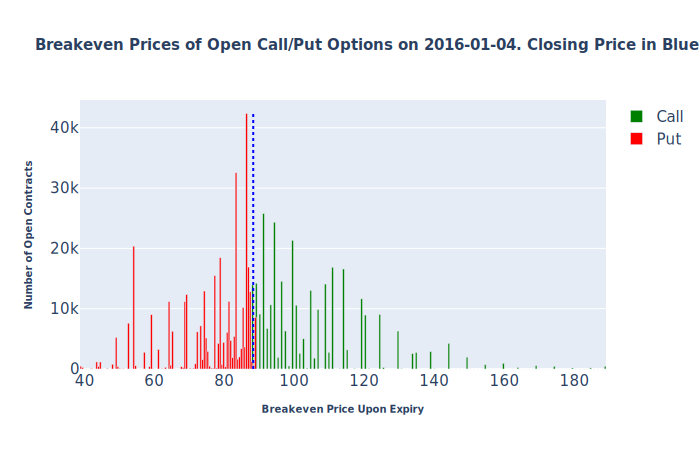

In [100]:
fig = go.Figure()
date = np.unique(options_df["date"])[0]

for my_df in [calls_df, puts_df]:
    temp_df = my_df[(my_df["date"] == date) & (my_df["open interest"] > 0)].reset_index(drop=True)
    my_min = np.min(temp_df["adj breakeven"])
    my_max = np.max(temp_df["adj breakeven"])
    # bins used for histogram
    [my_bins, my_step] = np.linspace(start=my_min,
                                     stop=my_max,
                                     num=num_bars + 1,
                                     retstep=True)
    # Obtain which bin each adjusted breakeven price belongs
    my_indices = np.digitize(x=temp_df["adj breakeven"],
                             bins=my_bins,
                             right=True)
    # Subtract one since indicies start with "1"
    my_indices = my_indices - 1
    x_axis = np.linspace(start=my_min + 0.5 * my_step,
                         stop=my_max - 0.5 * my_step,
                         num=num_bars)
    y_axis = pd.Series(np.zeros(num_bars))
    for n in range(temp_df.shape[0]):
        y_axis.iloc[my_indices[n]] += temp_df.loc[n, "open interest"]

    if all(temp_df["type"] == "call"):
        my_color = "green"
        my_legend = "Call"
    else:
        my_color = "red"
        my_legend = "Put"

    fig.add_trace(go.Bar(x=x_axis,
                         y=y_axis,
                         marker_color=my_color,
                         name=my_legend,
                         width=0.5))

fig.add_shape(dict(
    type="line",
    x0=np.unique(temp_df["adj closing"])[0],
    y0=0,
    x1=np.unique(temp_df["adj closing"])[0],
    y1=max(y_axis),
    line=dict(
        color="blue",
        dash="dot",
        width=2
    )
))

fig.update_layout(
    title=dict(text="<b>Breakeven Prices of Open Call/Put Options on <b>" +
               str(date) + "<b>. Closing Price in Blue<b>",
               font=dict(size=15)),
    xaxis_title=dict(text="<b>Breakeven Price Upon Expiry<b>",
                     font=dict(size=10)),
    yaxis_title=dict(text="<b>Number of Open Contracts<b>",
                     font=dict(size=10)),
    font=dict(size=15)
)

fig.show("svg")